## Abstract<br>
This analysis investigates the relationship between player performance metrics and their market value.<br>
Using datasets comprising game appearances, player valuations, and detailed player information, the<br>
study focuses on two key player categories: attackers and defenders.<br>
The analysis aims to determine the Pearson correlation coefficients between market value and various<br>
performance metrics, including goals per game and assists per game, for these categories.<br>
Surprisingly, the results revealed low correlation coefficients for attackers, with goals per game<br>
and assists per game showing coefficients of 0.0266 and 0.0182, respectively.<br>
This indicates a weak linear relationship between these metrics and market value.<br><br>

Here are some potential reasons for this:

* <b>Complex Valuation Factors:</b> Market value is influenced by numerous factors beyond just goals<br>
and assists, such as player age, overall skillset, marketability, potential, injury history,<br>
and contract length.
* <b>Data Quality and Coverage:</b> Incomplete or noisy data can affect correlation results.
* <b>External Factors:</b> External factors like team strategy, league competitiveness,<br>
and economic conditions can influence market value independently of individual<br>
performance metrics.<br><br>

Overall, this study highlights the complexity of factors influencing player market value,<br>
suggesting that performance metrics alone may not fully capture the valuation determinants.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import string
from scipy.stats import pearsonr
import dask.dataframe as dd
plt.style.use('ggplot')
# pd.set_option('max_columns', 200)


In [2]:
df_games = pd.read_csv('AssignmentData/games.csv')
df_app = pd.read_csv('AssignmentData/appearances.csv')
df_player_val = pd.read_csv('AssignmentData/player_valuations.csv')

df_club_games = pd.read_csv('AssignmentData/club_games.csv')
df_club = pd.read_csv('AssignmentData/clubs.csv')
df_comp = pd.read_csv('AssignmentData/competitions.csv')
df_game_events = pd.read_csv('AssignmentData/game_events.csv')
df_game_lineups = pd.read_csv('AssignmentData/game_lineups.csv')
df_players = pd.read_csv('AssignmentData/players.csv')
pd.set_option('display.max_columns', None) # Display all columns

In [3]:
# Optimize data types
df_app['game_id'] = df_app['game_id'].astype('int32')
df_app['player_id'] = df_app['player_id'].astype('int32')
df_app['goals'] = df_app['goals'].astype('int16')
df_app['assists'] = df_app['assists'].astype('int16')
df_app['minutes_played'] = df_app['minutes_played'].astype('int16')

df_player_val['player_id'] = df_player_val['player_id'].astype('int32')
df_player_val['market_value_in_eur'] = df_player_val['market_value_in_eur'].astype('float32')

df_games['game_id'] = df_games['game_id'].astype('int32')

### Data Cleaning for df_games

In [4]:
df_games.columns

Index(['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee', 'url',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type'],
      dtype='object')

In [5]:
df_games = df_games[['game_id', 'season', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_name',
       'away_club_name', 'aggregate']]
df_games.head(5)

,game_id,season,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_name,away_club_name,aggregate
0,2222597,2012,2012-08-25,3725,232,2,1,RFK Akhmat Grozny,FK Spartak Moskva,2:1
1,2222627,2012,2012-08-20,2696,4128,0,2,PFK Krylya Sovetov Samara,Amkar Perm,0:2
2,2222658,2012,2012-09-30,2410,121,0,2,PFK CSKA Moskva,FK Dinamo Moskva,0:2
3,2222664,2012,2012-09-15,932,2698,1,0,"Футбольный клуб ""Локомотив"" Москва",FC Rubin Kazan,1:0
4,2222683,2012,2012-10-22,2696,12438,0,1,PFK Krylya Sovetov Samara,Volga Nizhniy Novgorod (- 2016),0:1


### Data Cleaning for df_app

In [6]:
df_app.columns

Index(['appearance_id', 'game_id', 'player_id', 'player_club_id',
       'player_current_club_id', 'date', 'player_name', 'competition_id',
       'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played'],
      dtype='object')

In [7]:
df_app = df_app[
['appearance_id', 'game_id', 'player_id', 'player_club_id',
       'player_current_club_id', 'date', 'player_name',
        'goals', 'assists', 'minutes_played']
]

In [8]:
df_app = df_app.dropna(subset='goals')
df_app = df_app.dropna(subset='assists')
df_app = df_app.dropna(subset='minutes_played')

df_app.head(5)

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,0,1,90


### Data Cleaning for df_player_val

In [9]:
df_player_val.columns

Index(['player_id', 'last_season', 'datetime', 'date', 'dateweek',
       'market_value_in_eur', 'n', 'current_club_id',
       'player_club_domestic_competition_id'],
      dtype='object')

In [10]:
df_player_val = df_player_val[
['player_id', 'last_season', 'datetime', 'date',
       'market_value_in_eur', 'current_club_id']
]

In [11]:
df_player_val = df_player_val.dropna(subset='market_value_in_eur')
df_player_val.head(5)

,player_id,last_season,datetime,date,market_value_in_eur,current_club_id
0,3132,2013,2003-12-09 00:00:00,2003-12-09,400000.0,126
1,6893,2012,2003-12-15 00:00:00,2003-12-15,900000.0,984
2,10,2015,2004-10-04 00:00:00,2004-10-04,7000000.0,398
3,26,2017,2004-10-04 00:00:00,2004-10-04,1500000.0,16
4,65,2015,2004-10-04 00:00:00,2004-10-04,8000000.0,1091


### Data Cleaning for df_players

In [12]:
df_players = df_players[
['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id','sub_position', 'position',
       'market_value_in_eur',
       'current_club_name']
]

In [13]:
df_players = df_players.dropna(subset='market_value_in_eur')

In [14]:
df_players

,player_id,first_name,last_name,name,last_season,current_club_id,sub_position,position,market_value_in_eur,current_club_name
7,4042,Brad,Jones,Brad Jones,2017,234,Goalkeeper,Goalkeeper,100000.0,Feyenoord Rotterdam
33,8187,Juanmi,Callejón,Juanmi Callejón,2012,2672,Left Winger,Attack,200000.0,APO Levadiakos
72,18922,Karim,Benzema,Karim Benzema,2022,418,Centre-Forward,Attack,25000000.0,Real Madrid
89,22860,Jesper,Hansen,Jesper Hansen,2023,678,Goalkeeper,Goalkeeper,200000.0,Aarhus GF
93,23365,NaN,Reginaldo,Reginaldo,2012,1387,Centre-Forward,Attack,10000.0,Siena FC
...,...,...,...,...,...,...,...,...,...,...
30297,371851,Jaka,Bijol,Jaka Bijol,2023,410,Centre-Back,Defender,10000000.0,Udinese Calcio
30298,537171,Semuel,Pizzignacco,Semuel Pizzignacco,2018,410,Goalkeeper,Goalkeeper,325000.0,Udinese Calcio
30299,586756,Festy,Ebosele,Festy Ebosele,2023,410,Right Midfield,Midfield,4500000.0,Udinese Calcio
30300,704692,Nicolò,Cocetta,Nicolò Cocetta,2022,410,Centre-Back,Defender,75000.0,Udinese Calcio


### Merge appearances (df_app) with games (df_games) first on game_id

In [15]:
# Merge appearances with games first on game_id
df_merged = df_app.merge(df_games, on='game_id', how='inner')

In [16]:
df_merged = df_merged.drop(columns='player_club_id')
df_merged = df_merged.drop(columns='player_current_club_id')
df_merged = df_merged.drop(columns='home_club_name')
df_merged = df_merged.drop(columns='away_club_name')
df_merged = df_merged.drop(columns='date_y')
df_merged.rename(columns={'date_x': 'date'}, inplace=True)

In [17]:
df_merged.head(5)

,appearance_id,game_id,player_id,date,player_name,goals,assists,minutes_played,season,home_club_id,away_club_id,home_club_goals,away_club_goals,aggregate
0,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0
1,2233748_79232,2233748,79232,2012-07-05,Ruslan Abyshov,0,0,90,2012,8841,22783,2,2,2:2
2,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1
3,2234418_73333,2234418,73333,2012-07-05,Vegar Hedenstad,0,0,90,2012,3779,1274,2,0,2:0
4,2234421_122011,2234421,122011,2012-07-05,Markus Henriksen,0,1,90,2012,21532,195,0,3,0:3


### Merge the result with player valuation on player_id

In [18]:
df_mergedz = df_merged.merge(df_player_val, on='player_id', how='inner').copy()
df_mergedz = df_mergedz.drop(columns='date_y')
df_mergedz.rename(columns={'date_x': 'date'}, inplace=True)

In [19]:
df_mergedz

,appearance_id,game_id,player_id,date,player_name,goals,assists,minutes_played,season,home_club_id,away_club_id,home_club_goals,away_club_goals,aggregate,last_season,datetime,market_value_in_eur,current_club_id
0,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0,2013,2006-02-15 00:00:00,75000.0,235
1,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0,2013,2009-01-11 00:00:00,75000.0,235
2,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0,2013,2010-01-04 00:00:00,175000.0,235
3,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0,2013,2012-10-09 00:00:00,300000.0,235
4,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0,2013,2013-01-17 00:00:00,500000.0,235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36542517,4098878_580434,4098878,580434,2023-11-26,Tobe Leysen,0,0,90,2023,2727,2282,0,1,0:1,2023,2022-11-04 00:00:00,400000.0,2727
36542518,4098878_580434,4098878,580434,2023-11-26,Tobe Leysen,0,0,90,2023,2727,2282,0,1,0:1,2023,2023-06-09 00:00:00,300000.0,2727
36542519,4172110_624258,4172110,624258,2023-11-30,Conor Bradley,0,0,8,2023,31,413,4,0,4:0,2021,2021-10-05 00:00:00,400000.0,31
36542520,4172110_624258,4172110,624258,2023-11-30,Conor Bradley,0,0,8,2023,31,413,4,0,4:0,2021,2022-06-15 00:00:00,1000000.0,31


### Calculate performance metrics

In [20]:
df_mergedz['goals_per_game'] = df_mergedz['goals'] / df_mergedz['minutes_played']
df_mergedz['assists_per_game'] = df_mergedz['assists'] / df_mergedz['minutes_played']
df_mergedz.head(5)

,appearance_id,game_id,player_id,date,player_name,goals,assists,minutes_played,season,home_club_id,away_club_id,home_club_goals,away_club_goals,aggregate,last_season,datetime,market_value_in_eur,current_club_id,goals_per_game,assists_per_game
0,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0,2013,2006-02-15 00:00:00,75000.0,235,0.022222,0.0
1,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0,2013,2009-01-11 00:00:00,75000.0,235,0.022222,0.0
2,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0,2013,2010-01-04 00:00:00,175000.0,235,0.022222,0.0
3,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0,2013,2012-10-09 00:00:00,300000.0,235,0.022222,0.0
4,2231978_38004,2231978,38004,2012-07-03,Aurélien Joachim,2,0,90,2012,853,10747,7,0,7:0,2013,2013-01-17 00:00:00,500000.0,235,0.022222,0.0


### Define Attack and Defender Criteria
Assuming attackers are forwards and midfielders, and defenders are defenders.

In [21]:
attack_positions = ['Attack', 'Midfield']
defender_positions = ['Defender']

### Merge DataFrames
Merge df_players with df_mergedz to get position information for each player

In [22]:
df_position = df_players[['player_id', 'position']]
df_mergedz = df_mergedz.merge(df_position, on='player_id', how='left')

In [23]:
# Remove rows with Nan value in position field
df_mergedz.dropna(subset='position', inplace=True)

In [24]:
df_mergedz.head(5)

,appearance_id,game_id,player_id,date,player_name,goals,assists,minutes_played,season,home_club_id,away_club_id,home_club_goals,away_club_goals,aggregate,last_season,datetime,market_value_in_eur,current_club_id,goals_per_game,assists_per_game,position
1480,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2008-07-05 00:00:00,150000.0,465,0.0,0.0,Midfield
1481,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2009-08-27 00:00:00,250000.0,465,0.0,0.0,Midfield
1482,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2009-12-26 00:00:00,500000.0,465,0.0,0.0,Midfield
1483,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2010-01-18 00:00:00,400000.0,465,0.0,0.0,Midfield
1484,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2010-09-23 00:00:00,600000.0,465,0.0,0.0,Midfield


### Calculate Pearson Correlation Coefficients
Calculates the correlation coefficients for attackers and defenders separately

In [25]:
# Define the performance metrics
performance_metrics = ['goals_per_game', 'assists_per_game']

# Filter data for attackers and calculate correlations
attackers = df_mergedz[df_mergedz['position'].isin(attack_positions)]
defenders = df_mergedz[df_mergedz['position'].isin(defender_positions)]

# Calculate correlations for attackers
attack_correlations = {}
for metric in performance_metrics:
    attack_corr, _ = pearsonr(attackers['market_value_in_eur'], attackers[metric].fillna(0))
    attack_correlations[metric] = attack_corr

# Calculate correlations for defenders
defender_correlations = {}
for metric in performance_metrics:
    defend_corr, _ = pearsonr(defenders['market_value_in_eur'], defenders[metric].fillna(0))
    defender_correlations[metric] = defend_corr

print("Correlation coefficients for attackers:")
print(attack_correlations)

print("\nCorrelation coefficients for defenders:")
print(defender_correlations)


Correlation coefficients for attackers:
{'goals_per_game': 0.026599515175713656, 'assists_per_game': 0.018240176737240966}

Correlation coefficients for defenders:
{'goals_per_game': 0.0064723960960545186, 'assists_per_game': 0.005886325251000222}


### Minutes and market value mean 

In [26]:
mean_minutes_played = df_mergedz['minutes_played'].mean()
mean_market_value_in_eur = df_mergedz['market_value_in_eur'].mean()

print(mean_minutes_played)
print(mean_market_value_in_eur)

70.7782491074893
6572161.0


### Set thresholds

In [27]:
# min_minutes_played = 50
# min_market_value = 1000000

# mean_minutes_played

### Define bins and labels based on deviation from mean

In [28]:
minutes_bins = [float('-inf'), 20, 40, 60, 80, 100, float('inf')]
minutes_labels = ['Very Low', 'Low', 'Average', 'Above Average', 'High', 'Very High']

market_value_bins = [float('-inf'), mean_market_value_in_eur * 0.5, mean_market_value_in_eur * 0.75, mean_market_value_in_eur, mean_market_value_in_eur * 1.25, mean_market_value_in_eur * 1.5, float('inf')]
market_value_labels = ['Very Low', 'Low', 'Average', 'Above Average', 'High', 'Very High']

### Categorize data into bins

In [30]:
df_mergedz['minutes_played_bin'] = pd.cut(df_mergedz['minutes_played'], bins=minutes_bins, labels=minutes_labels)
df_mergedz['market_value_bin'] = pd.cut(df_mergedz['market_value_in_eur'], bins=market_value_bins, labels=market_value_labels)

In [31]:
df_mergedz.head(5)

,appearance_id,game_id,player_id,date,player_name,goals,assists,minutes_played,season,home_club_id,away_club_id,home_club_goals,away_club_goals,aggregate,last_season,datetime,market_value_in_eur,current_club_id,goals_per_game,assists_per_game,position,minutes_played_bin,market_value_bin
1480,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2008-07-05 00:00:00,150000.0,465,0.0,0.0,Midfield,Average,Very Low
1481,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2009-08-27 00:00:00,250000.0,465,0.0,0.0,Midfield,Average,Very Low
1482,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2009-12-26 00:00:00,500000.0,465,0.0,0.0,Midfield,Average,Very Low
1483,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2010-01-18 00:00:00,400000.0,465,0.0,0.0,Midfield,Average,Very Low
1484,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2010-09-23 00:00:00,600000.0,465,0.0,0.0,Midfield,Average,Very Low


### Separate data for attackers and defenders

In [32]:
attackers = df_mergedz[df_mergedz['position'].isin(attack_positions)]
defenders = df_mergedz[df_mergedz['position'].isin(defender_positions)]
attackers

,appearance_id,game_id,player_id,date,player_name,goals,assists,minutes_played,season,home_club_id,away_club_id,home_club_goals,away_club_goals,aggregate,last_season,datetime,market_value_in_eur,current_club_id,goals_per_game,assists_per_game,position,minutes_played_bin,market_value_bin
1480,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2008-07-05 00:00:00,150000.0,465,0.0,0.0,Midfield,Average,Very Low
1481,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2009-08-27 00:00:00,250000.0,465,0.0,0.0,Midfield,Average,Very Low
1482,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2009-12-26 00:00:00,500000.0,465,0.0,0.0,Midfield,Average,Very Low
1483,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2010-01-18 00:00:00,400000.0,465,0.0,0.0,Midfield,Average,Very Low
1484,2234413_42792,2234413,42792,2012-07-05,Sander Puri,0,0,45,2012,6251,11915,2,1,2:1,2012,2010-09-23 00:00:00,600000.0,465,0.0,0.0,Midfield,Average,Very Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36542506,4222126_555166,4222126,555166,2023-11-29,Maksim Laykin,0,0,45,2023,14589,232,1,0,1:0,2023,2021-12-07 00:00:00,200000.0,232,0.0,0.0,Midfield,Average,Very Low
36542507,4222126_555166,4222126,555166,2023-11-29,Maksim Laykin,0,0,45,2023,14589,232,1,0,1:0,2023,2022-05-30 00:00:00,275000.0,232,0.0,0.0,Midfield,Average,Very Low
36542508,4222126_555166,4222126,555166,2023-11-29,Maksim Laykin,0,0,45,2023,14589,232,1,0,1:0,2023,2022-09-12 00:00:00,300000.0,232,0.0,0.0,Midfield,Average,Very Low
36542509,4222126_555166,4222126,555166,2023-11-29,Maksim Laykin,0,0,45,2023,14589,232,1,0,1:0,2023,2022-12-08 00:00:00,400000.0,232,0.0,0.0,Midfield,Average,Very Low


In [33]:
# Define performance metrics
performance_metrics = ['goals_per_game', 'assists_per_game']


In [36]:
# Calculate Pearson correlation coefficients for attackers and defenders
attack_correlations = {metric: pearsonr(attackers[metric], attackers['market_value_in_eur'])[0] for metric in performance_metrics}
defender_correlations = {metric: pearsonr(defenders[metric], defenders['market_value_in_eur'])[0] for metric in performance_metrics}


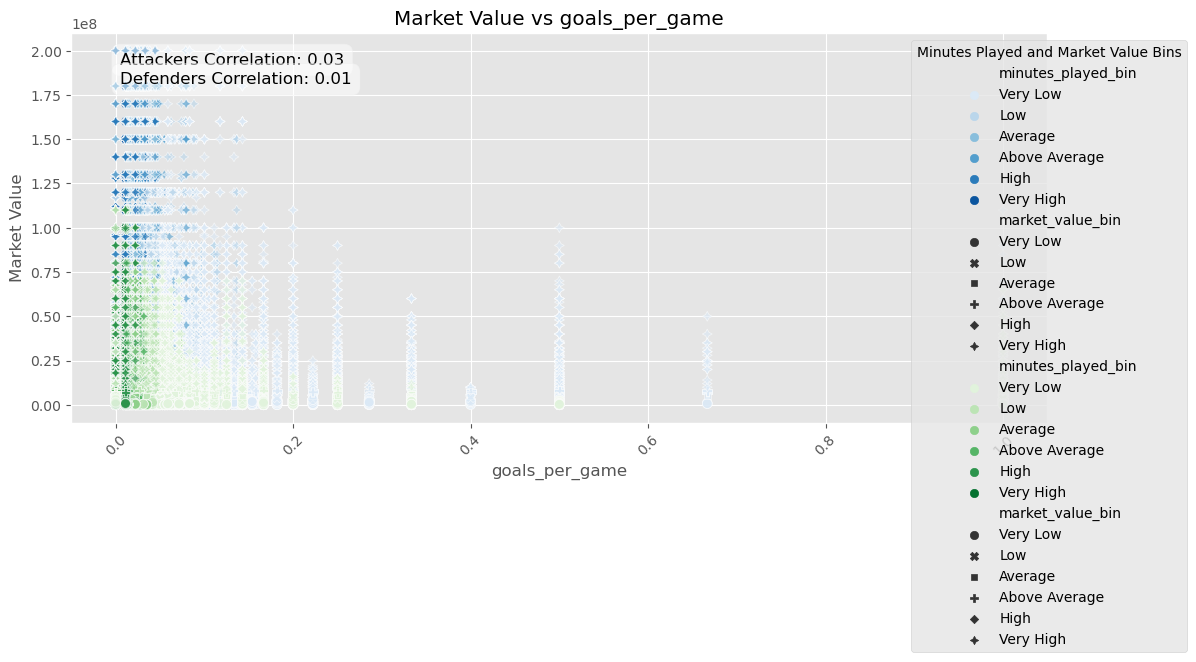

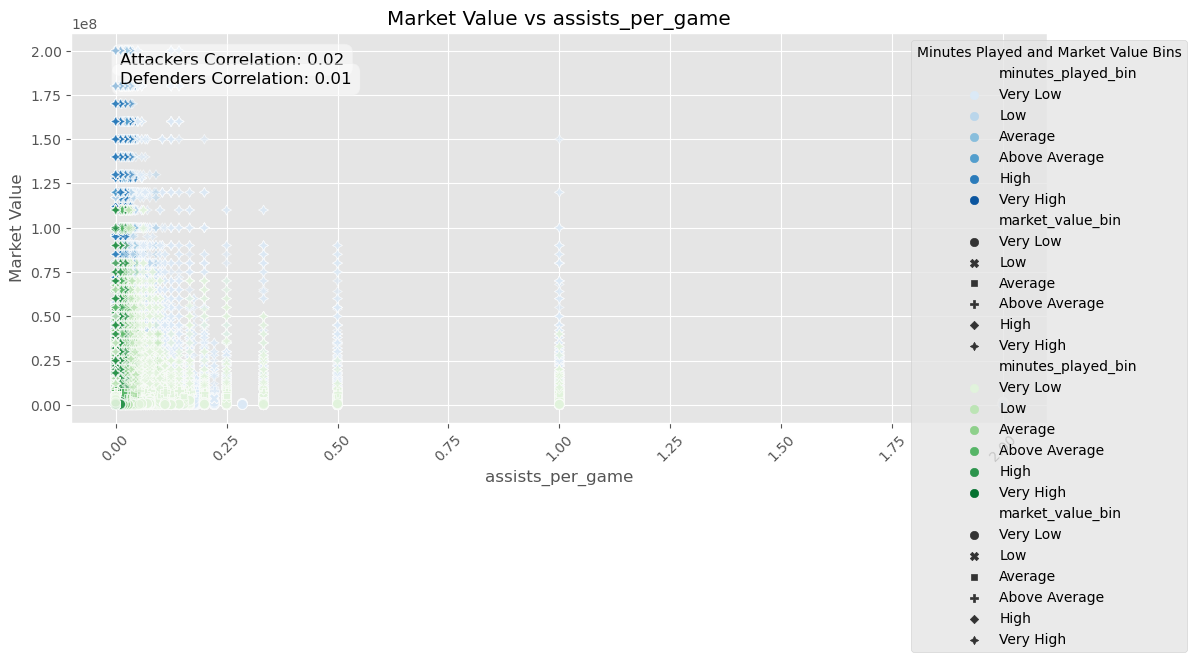

In [37]:
# Scatter plot with bins
for metric in performance_metrics:
    plt.figure(figsize=(12, 6))
    
    # Scatter plot for attackers
    sns.scatterplot(x=metric, y='market_value_in_eur', hue='minutes_played_bin', style='market_value_bin',
                    data=attackers, palette='Blues', alpha=0.6, s=50, marker='o')
    
    # Scatter plot for defenders
    sns.scatterplot(x=metric, y='market_value_in_eur', hue='minutes_played_bin', style='market_value_bin',
                    data=defenders, palette='Greens', alpha=0.6, s=50, marker='X')
    
    plt.title(f'Market Value vs {metric}')
    plt.xlabel(metric)
    plt.ylabel('Market Value')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Annotate the plot with correlation coefficients
    correlation_text_attackers = f'Attackers Correlation: {attack_correlations[metric]:.2f}'
    correlation_text_defenders = f'Defenders Correlation: {defender_correlations[metric]:.2f}'
    plt.annotate(correlation_text_attackers, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
    plt.annotate(correlation_text_defenders, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
    
    plt.legend(title='Minutes Played and Market Value Bins', loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()